# Neural network architectures: Simple shear


### See following publication for details:
Mital, U., Andrade, J.E. Bridging length scales in granular materials using convolutional neural networks. Comp. Part. Mech. (2021). https://doi.org/10.1007/s40571-021-00405-1

**Note:** Due to inherent stochasticity, mean absolute errors of the models are not exactly the same as those reported in the manuscript. But they are similar.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import os, glob

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
K.set_image_data_format('channels_last')

from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(font_scale=1.35, style='white')

Using TensorFlow backend.


## Read the data: Simple shear (Can ignore the next cell)

Experimental data (not provided) is obtained from the following publication:

Marteau, E., Andrade, J.E. A novel experimental device for investigating the multiscale behavior of granular materials under shear. Granular Matter 19, 77 (2017). https://doi.org/10.1007/s10035-017-0766-x

X_data is arranged as follows (number_of_timesteps, number_of_contacts, number_of_channels) <br>
X_data channels (Fx, Fy in kN/m; Dx, Dy in cm; helps with feature scaling): <br>
Fx | Fy | Dx | Dy

Y_data (shear stress $\tau$ in N/m$^2$) <br>

Load curve shown in Figure 5 of Mital and Andrade (2021).

time refers to the timestep corresponding to an index. There are 998 indices but timesteps are from 1 to 1000. Data for two timesteps is missing.

**Note: In what follows, num_pixels refers to number_of_contacts**

In [2]:
########## Some script to read experimental data (can ignore) ###############
os.chdir('data_regression/')
path = os.getcwd()
count = 0
data = []    
for infile in glob.glob( os.path.join(path, '*.dat') ):
    data.append(np.loadtxt(infile))
    count += 1

os.chdir('..')

data = np.asarray(data)
timesteps = data[:,-1,-1] 
sorted_indices = np.argsort(timesteps)
time = timesteps[sorted_indices]

X_data = data[sorted_indices,0:-1]

y_data = -data[sorted_indices,-1,0:-1]/1000 
y_tau = y_data[:,2]
###################################################################################


num_timesteps = X_data.shape[0] # 998
num_pixels = X_data.shape[1] # 665; 
num_channels = X_data.shape[2] # Fx, Fy, Dx, Dy: analogous to RGB for images

### Reshape the data to what's needed for neural nets

In [3]:
X_data_reshaped = X_data.reshape(X_data.shape[0], num_pixels, 1, num_channels)
print (X_data.shape)
print (X_data_reshaped.shape)

(998, 665, 4)
(998, 665, 1, 4)


## Experiment 4: CNN architecture

In [4]:
def CNN_model_Exp4():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 1), input_shape=(665, 1, num_channels), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [5]:
model = CNN_model_Exp4()

# Split data into training and test
X_train, X_test, y_train, y_test, time_train, time_test = (
    train_test_split(X_data_reshaped, y_tau, time, test_size=0.5, random_state=50))
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

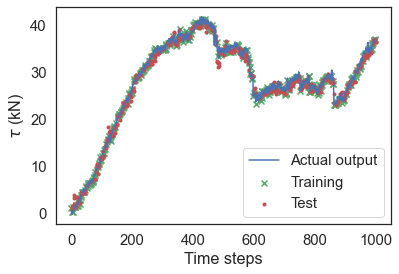

In [6]:
plt.scatter(time_train, model.predict([X_train]),label='Training', color='g', marker='x')
plt.scatter(time_test, model.predict([X_test]),label='Test', color='r', marker='.')
plt.plot(time, y_tau,'-',label='Actual output')
plt.legend(loc=0)
plt.xlabel('Time steps')
plt.ylabel(r'$\tau$ (kN)')
plt.show()

### Mean absolute error (training)

In [7]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.3449787907200426

### Mean absolute error (testing)

In [8]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

0.6336322725352477

## Experiment 5: CNN architecture

In [9]:
np.random.seed(50)
random_indices = np.random.choice(np.arange(num_pixels),100,replace=False)
X_data_partial_random = X_data_reshaped[:,random_indices,:,:]

X_data_partial_contiguous = X_data_reshaped[:,0:100,:,:]

In [10]:
print (X_data_partial_random.shape)
print (X_data_partial_contiguous.shape)

(998, 100, 1, 4)
(998, 100, 1, 4)


In [11]:
def CNN_model_Exp5():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 1), input_shape=(100, 1, num_channels), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

## Experiment 5: Randomly picked contacts

In [12]:
model = CNN_model_Exp5()

# Split data into training and test
X_train, X_test, y_train, y_test, time_train, time_test = (
    train_test_split(X_data_partial_random, y_tau, time, test_size=0.5, random_state=50))
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

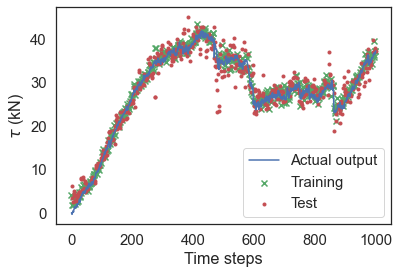

In [13]:
plt.scatter(time_train, model.predict([X_train]),label='Training', color='g', marker='x')
plt.scatter(time_test, model.predict([X_test]),label='Test', color='r', marker='.')
plt.plot(time, y_tau,'-',label='Actual output')
plt.legend(loc=0)
plt.xlabel('Time steps')
plt.ylabel(r'$\tau$ (kN)')
plt.show()

### Mean absolute error (training)

In [14]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.8843705270237529

### Mean absolute error (testing)

In [15]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

1.7608823502863016

## Experiment 5: Contiguous contacts

In [16]:
model = CNN_model_Exp5()

# Split data into training and test
X_train, X_test, y_train, y_test, time_train, time_test = (
    train_test_split(X_data_partial_contiguous, y_tau, time, test_size=0.5, random_state=50))
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

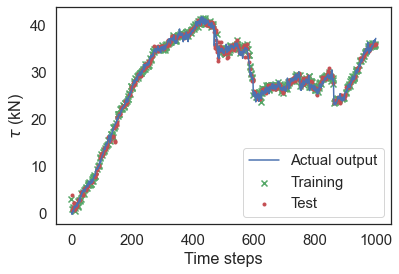

In [17]:
plt.scatter(time_train, model.predict([X_train]),label='Training', color='g', marker='x')
plt.scatter(time_test, model.predict([X_test]),label='Test', color='r', marker='.')
plt.plot(time, y_tau,'-',label='Actual output')
plt.legend(loc=0)
plt.xlabel('Time steps')
plt.ylabel(r'$\tau$ (kN)')
plt.show()

### Mean absolute error (training)

In [18]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.4229083999129005

### Mean absolute error (testing)

In [19]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

0.5160717926391475

## Experiment 6: Noisy dataset, all contacts

In [20]:
X_data_noisy = X_data_reshaped + np.random.normal(0,1,[X_data.shape[0],665,1,num_channels])

In [21]:
model = CNN_model_Exp4()

X_train, X_test, y_train, y_test, time_train, time_test = (
    train_test_split(X_data_noisy, y_tau, time, test_size=0.5, random_state=50))
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

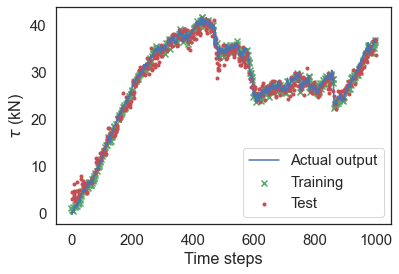

In [22]:
plt.scatter(time_train, model.predict([X_train]),label='Training', color='g', marker='x')
plt.scatter(time_test, model.predict([X_test]),label='Test', color='r', marker='.')
plt.plot(time, y_tau,'-',label='Actual output')
plt.legend(loc=0)
plt.xlabel('Time steps')
plt.ylabel(r'$\tau$ (kN)')
plt.show()

### Mean absolute error (training)

In [23]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.3573725400782023

### Mean absolute error (testing)

In [24]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

1.169789242288849

## Experiment 6: Noisy dataset, partial contacts

In [25]:
X_data_partial_noisy = X_data_partial_contiguous + np.random.normal(0,1,[X_data_partial_contiguous.shape[0],100,1,num_channels])

In [26]:
model = CNN_model_Exp5()

X_train, X_test, y_train, y_test, time_train, time_test = (
    train_test_split(X_data_partial_noisy, y_tau, time, test_size=0.5, random_state=50))
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

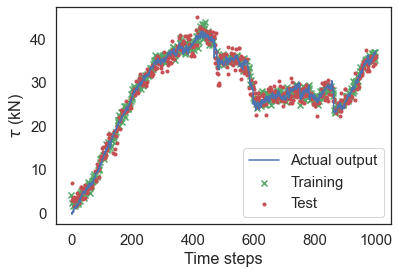

In [27]:
plt.scatter(time_train, model.predict([X_train]),label='Training', color='g', marker='x')
plt.scatter(time_test, model.predict([X_test]),label='Test', color='r', marker='.')
plt.plot(time, y_tau,'-',label='Actual output')
plt.legend(loc=0)
plt.xlabel('Time steps')
plt.ylabel(r'$\tau$ (kN)')
plt.show()

### Mean absolute error (training)

In [28]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.676551782484014

### Mean absolute error (testing)

In [29]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

1.3084212620736926

## Experiment 7: Time-biased training (all contacts)

In [30]:
# Split data into training and test
model = CNN_model_Exp4()
split_point = 499

X_train = X_data_reshaped[0:split_point]
X_test = X_data_reshaped[split_point:]
y_train = y_tau[0:split_point]
y_test = y_tau[split_point:]
time_train = time[0:split_point]
time_test = time[split_point:]

model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

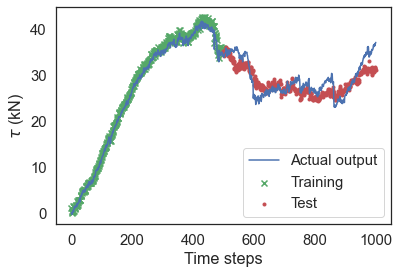

In [31]:
plt.scatter(time_train, model.predict([X_train]),label='Training', color='g', marker='x')
plt.scatter(time_test, model.predict([X_test]),label='Test', color='r', marker='.')
plt.plot(time, y_tau,'-',label='Actual output')
plt.legend(loc=0)
plt.xlabel('Time steps')
plt.ylabel(r'$\tau$ (kN)')
plt.show()

### Mean absolute error (training)

In [32]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.6558605041550142

### Mean absolute error (testing)

In [33]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

1.864017488273375

## Experiment 7: Time-biased training (all contacts with added gaussian noise)

In [34]:
# Split data into training and test
model = CNN_model_Exp4()
split_point = 499

X_train = X_data_noisy[0:split_point]
X_test = X_data_noisy[split_point:]
y_train = y_tau[0:split_point]
y_test = y_tau[split_point:]
time_train = time[0:split_point]
time_test = time[split_point:]

model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

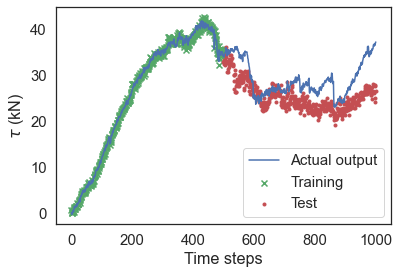

In [35]:
plt.scatter(time_train, model.predict([X_train]),label='Training', color='g', marker='x')
plt.scatter(time_test, model.predict([X_test]),label='Test', color='r', marker='.')
plt.plot(time, y_tau,'-',label='Actual output')
plt.legend(loc=0)
plt.xlabel('Time steps')
plt.ylabel(r'$\tau$ (kN)')
plt.show()

### Mean absolute error (training)

In [36]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.40176731759525824

### Mean absolute error (testing)

In [37]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

4.000397171573483

## Experiment 7: Time-biased training (100 contiguous contacts)

In [38]:
# Split data into training and test
model = CNN_model_Exp5()
split_point = 499

X_train = X_data_partial_contiguous[0:split_point]
X_test = X_data_partial_contiguous[split_point:]
y_train = y_tau[0:split_point]
y_test = y_tau[split_point:]
time_train = time[0:split_point]
time_test = time[split_point:]

model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

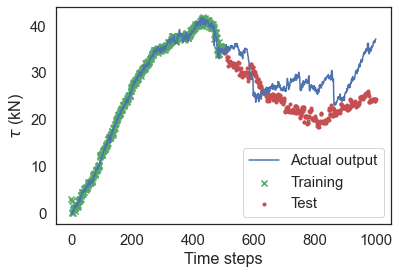

In [39]:
plt.scatter(time_train, model.predict([X_train]),label='Training', color='g', marker='x')
plt.scatter(time_test, model.predict([X_test]),label='Test', color='r', marker='.')
plt.plot(time, y_tau,'-',label='Actual output')

plt.legend(loc=0)
plt.xlabel('Time steps')
plt.ylabel(r'$\tau$ (kN)')
plt.show()

### Mean absolute error (training)

In [40]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.36532658637405846

### Mean absolute error (testing)

In [41]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

5.072841002813335

## Experiment 7: Time-biased training (100 contiguous contacts with added gaussian noise)

In [42]:
# Split data into training and test
model = CNN_model_Exp5()
split_point = 499

X_train = X_data_partial_noisy[0:split_point]
X_test = X_data_partial_noisy[split_point:]
y_train = y_tau[0:split_point]
y_test = y_tau[split_point:]
time_train = time[0:split_point]
time_test = time[split_point:]

model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

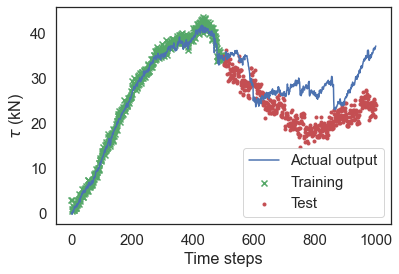

In [43]:
plt.scatter(time_train, model.predict([X_train]),label='Training', color='g', marker='x')
plt.scatter(time_test, model.predict([X_test]),label='Test', color='r', marker='.')
plt.plot(time, y_tau,'-',label='Actual output')
plt.legend(loc=0)
plt.xlabel('Time steps')
plt.ylabel(r'$\tau$ (kN)')
plt.show()

### Mean absolute error (training)

In [44]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.7594523009319625

### Mean absolute error (testing)

In [45]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

6.037612519548397

## Experiment 8: Pre-peak training data (training on first 400 time steps)

In [46]:
model = CNN_model_Exp4()
split_point = 399

X_train = X_data_reshaped[0:split_point]
X_test = X_data_reshaped[split_point:]
y_train = y_tau[0:split_point]
y_test = y_tau[split_point:]
time_train = time[0:split_point]
time_test = time[split_point:]

model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

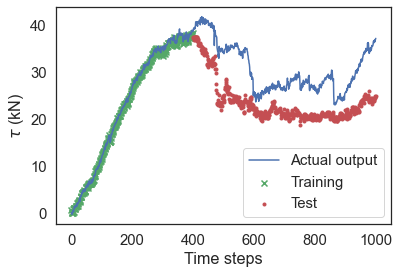

In [47]:
plt.scatter(time_train, model.predict([X_train]),label='Training', color='g', marker='x')
plt.scatter(time_test, model.predict([X_test]),label='Test', color='r', marker='.')
plt.plot(time, y_tau,'-',label='Actual output')
plt.legend(loc=0)
plt.xlabel('Time steps')
plt.ylabel(r'$\tau$ (kN)')
plt.show()

### Mean absolute error (training)

In [48]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.36473845492204726

### Mean absolute error (testing)

In [49]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

7.216839612388694

## Experiment 8: Pre-peak training data (training on first 300 time steps)

In [50]:
model = CNN_model_Exp4()
split_point = 299

X_train = X_data_reshaped[0:split_point]
X_test = X_data_reshaped[split_point:]
y_train = y_tau[0:split_point]
y_test = y_tau[split_point:]
time_train = time[0:split_point]
time_test = time[split_point:]

model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

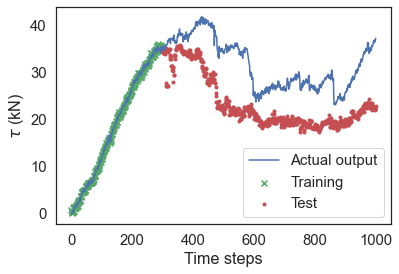

In [51]:
plt.scatter(time_train, model.predict([X_train]),label='Training', color='g', marker='x')
plt.scatter(time_test, model.predict([X_test]),label='Test', color='r', marker='.')
plt.plot(time, y_tau,'-',label='Actual output')
plt.legend(loc=0)
plt.xlabel('Time steps')
plt.ylabel(r'$\tau$ (kN)')
plt.show()

### Mean absolute error (training)

In [52]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.2347843071176452

### Mean absolute error (testing)

In [53]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

8.383534962508303

## Experiment 8: Deeper CNN

In [54]:
def CNN_model_Exp8_deep():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 1), input_shape=(X_data.shape[1], 1, num_channels), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Conv2D(64, (5, 1), input_shape=(X_data.shape[1], 1, num_channels), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

## Experiment 8: Pre-peak training data (training on first 400 time steps, Deeper CNN)

In [55]:
model = CNN_model_Exp8_deep()
split_point = 399

X_train = X_data_reshaped[0:split_point]
X_test = X_data_reshaped[split_point:]
y_train = y_tau[0:split_point]
y_test = y_tau[split_point:]
time_train = time[0:split_point]
time_test = time[split_point:]

model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

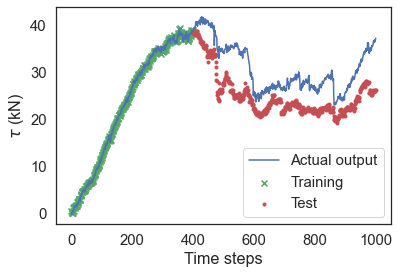

In [56]:
plt.scatter(time_train, model.predict([X_train]),label='Training', color='g', marker='x')
plt.scatter(time_test, model.predict([X_test]),label='Test', color='r', marker='.')
plt.plot(time, y_tau,'-',label='Actual output')
plt.legend(loc=0)
plt.xlabel('Time steps')
plt.ylabel(r'$\tau$ (kN)')
plt.show()

### Mean absolute error (training)

In [57]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.18151985884618912

### Mean absolute error (testing)

In [58]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

5.735894034783154

## Experiment 8: Pre-peak training data (training on first 300 time steps, Deeper CNN)

In [59]:
model = CNN_model_Exp8_deep()
split_point = 299

X_train = X_data_reshaped[0:split_point]
X_test = X_data_reshaped[split_point:]
y_train = y_tau[0:split_point]
y_test = y_tau[split_point:]
time_train = time[0:split_point]
time_test = time[split_point:]

model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

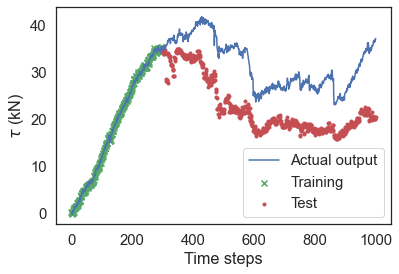

In [60]:
plt.scatter(time_train, model.predict([X_train]),label='Training', color='g', marker='x')
plt.scatter(time_test, model.predict([X_test]),label='Test', color='r', marker='.')
plt.plot(time, y_tau,'-',label='Actual output')
plt.legend(loc=0)
plt.xlabel('Time steps')
plt.ylabel(r'$\tau$ (kN)')
plt.show()

### Mean absolute error (training)

In [61]:
np.mean(np.abs(model.predict([X_train])[:,0] - y_train))

0.22350753370740045

### Mean absolute error (testing)

In [62]:
np.mean(np.abs(model.predict([X_test])[:,0] - y_test))

9.167429629105541

## Print model architectures

In [66]:
K.clear_session()

In [67]:
CNN_model_Exp4().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 661, 1, 32)        672       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 330, 1, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 330, 1, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10560)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1351808   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,352,609
Trainable params: 1,352,609
Non-trainable params: 0
____________________________________________

In [68]:
CNN_model_Exp5().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 96, 1, 32)         672       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 1, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 1, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               196736    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 197,537
Trainable params: 197,537
Non-trainable params: 0
________________________________________________

In [69]:
CNN_model_Exp8_deep().summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 661, 1, 32)        672       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 330, 1, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 326, 1, 64)        10304     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 163, 1, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 163, 1, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10432)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              